**Importing necessary packages**

In [ ]:
from tensorflow.keras.preprocessing import image
import cv2
import os, shutil
import matplotlib.pyplot as plt
import hashlib
import numpy as np
import random

In [ ]:
def data_aug(main_folder_path):
    dataset_folder = os.path.join(main_folder_path, 'augmented_images')
    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    # Define rotation angles and scales
    angles = [-30, 0, 30, 60, 90, 120, 150]
    scales = [1.0, 1.3, 1.5]

    # Iterate over each cow folder
    for cow_folder_name in os.listdir(main_folder_path):
        cow_folder_path = os.path.join(main_folder_path, cow_folder_name)
        if os.path.isdir(cow_folder_path):
            # Create a folder for the cow in the 'dataset' directory
            cow_dataset_folder = os.path.join(dataset_folder, cow_folder_name)
            if not os.path.exists(cow_dataset_folder):
                os.makedirs(cow_dataset_folder)

            # List all files in the cow folder
            image_files = [f for f in os.listdir(cow_folder_path) if os.path.isfile(os.path.join(cow_folder_path, f))]

            # Load and preprocess each cow image
            for i, image_file in enumerate(image_files):
                img_path = os.path.join(cow_folder_path, image_file)
                img = cv2.imread(img_path)

                # Generate augmented images
                for angle in angles:
                    for scale in scales:
                        M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), angle, scale)
                        rotated_image = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
                        # Define the filename for the augmented image
                        filename = f'augmented_{i}_angle{angle}_scale{scale}.jpg'
                        # Define the path to save the augmented image in the cow's dataset folder
                        save_path = os.path.join(cow_dataset_folder, filename)

                        # Save the augmented image
                        cv2.imwrite(save_path, rotated_image)
    print("Data Augmentation completed..")

def visualize(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  cow_nose_image = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]

  # Visualizing the original cow nose image
  plt.imshow(cow_nose_image)
  plt.axis('off')
  plt.show()


def img_preprocess(img_path):
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  # Resize images to 224x224
  img_resized = cv2.resize(img, (224, 224))

  # Apply contrast adjustment
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  img_resized = clahe.apply(img_resized)
  return img_resized


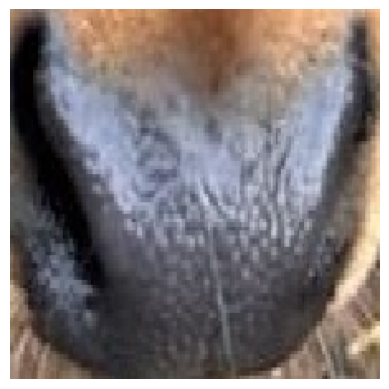

In [ ]:
img_path = '/content/drive/MyDrive/Muzzle Feature Extraction/SIFT/cows/cow1/nose1.jpg'
visualize(img_path)

**Function call to perform data augmentation**

In [ ]:
# Main directory containing cow folders
main_folder_path = '/content/drive/MyDrive/Muzzle Feature Extraction/SIFT/cows'

data_aug(main_folder_path)

Data Augmentation completed..


**Data Splitting**

In [ ]:
# Define the path to your cow folders
cow_folder_path = '/content/drive/MyDrive/Muzzle Feature Extraction/SIFT/cows/augmented_images'
output_train_path = '/content/drive/MyDrive/Muzzle Feature Extraction/SIFT/dataset/training'
output_val_path = '/content/drive/MyDrive/Muzzle Feature Extraction/SIFT/dataset/validation'

# Define the ratio for splitting data
train_ratio = 0.9  # 90% for training, 10% for validation

# Create directories for training and validation data if they don't exist
os.makedirs(output_train_path, exist_ok=True)
os.makedirs(output_val_path, exist_ok=True)

for folder_name in os.listdir(cow_folder_path):
    folder_path = os.path.join(cow_folder_path, folder_name)

    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        random.shuffle(images)  # Shuffle the images

        # Calculate the split indices based on the ratio
        split_index = int(len(images) * train_ratio)

        # Split the images into training and validation sets
        train_images = images[:split_index]
        val_images = images[split_index:]

        # Create directories for training and validation data for each cow folder
        train_folder = os.path.join(output_train_path, folder_name)
        val_folder = os.path.join(output_val_path, folder_name)
        os.makedirs(train_folder, exist_ok=True)
        os.makedirs(val_folder, exist_ok=True)

        # Move training images to the training folder with cow folder structure
        for image in train_images:
            src = os.path.join(folder_path, image)
            dst = os.path.join(train_folder, image)
            shutil.copy(src, dst)

        # Move validation images to the validation folder with cow folder structure
        for image in val_images:
            src = os.path.join(folder_path, image)
            dst = os.path.join(val_folder, image)
            shutil.copy(src, dst)


**Initialize dictionary for first time**

In [ ]:
# Initialize an empty dictionary to store features
cow_features = {}

**Extract the features from all nose images of the cow**

In [ ]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

def extract_features(cow_key, cow_folder_path):
  # Check if the cow_key already exists in the dictionary
  if cow_key in cow_features:
      print(f"Key: {cow_key} already exist.")
  else:
      # Initialize an empty dictionary to store features and unique_id for this cow
      cow_features[cow_key] = {'features': [], 'unique_id': None}

      # Iterate through the nose images of cow folder
      for img_file in os.listdir(cow_folder_path):
          if img_file.endswith('.jpg'):
              img_path = os.path.join(cow_folder_path, img_file)
              cow_nose_image = img_preprocess(img_path)

              # Detect and compute SIFT keypoints and descriptors
              keypoints, descriptors = sift.detectAndCompute(cow_nose_image, None)
              cow_features[cow_key]['features'].append(descriptors)

              # Draw keypoints on the original image
              image_with_keypoints = cv2.drawKeypoints(cow_nose_image, keypoints, None,
                                                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

              image_rgb = cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)

              # Plot the image with keypoints
              plt.figure(figsize=(6, 4))
              plt.imshow(image_rgb)
              plt.title(f"Keypoints for {cow_key} - {img_file}")
              plt.axis('off')
              plt.show()

      # Generate a unique ID using a hash function
      feature_str = str(cow_features[cow_key]['features']) # converting features to string
      unique_id = hashlib.md5(feature_str.encode()).hexdigest() # converts to hexadecimal representation

      # Check if the unique_id already exists in the dictionary
      if any(data['unique_id'] == unique_id for data in cow_features.values()):
          print("This feature already exists.")
          del cow_features[cow_key]
      else:
          # Assign the features and unique_id to cow_key in the dictionary
          cow_features[cow_key]['unique_id'] = unique_id
          print(f"Features extraction from {cow_key}'s muzzle completed. Unique ID: {unique_id}")


**Change path of each cow folder and enter respective cow's name**

In [ ]:
# Add New Cow
name_of_cow = input("Enter the cow name: ")

# Define the path to the folder for cow
# cow_folder_path = '/content/drive/MyDrive/Muzzle Feature Extraction/SIFT/dataset/training/cow1'
# cow_folder_path = '/content/drive/MyDrive/Muzzle Feature Extraction/SIFT/dataset/training/cow2'
# cow_folder_path = '/content/drive/MyDrive/Muzzle Feature Extraction/SIFT/dataset/training/cow3'
# cow_folder_path = '/content/drive/MyDrive/Muzzle Feature Extraction/SIFT/dataset/training/cow4'
# cow_folder_path = '/content/drive/MyDrive/Muzzle Feature Extraction/SIFT/dataset/training/cow5'
cow_folder_path = '/content/drive/MyDrive/Muzzle Feature Extraction/SIFT/dataset/training/cow6'

extract_features(name_of_cow, cow_folder_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Display the dictionary
print(cow_features)

{'cow1': {'features': [array([[  0.,   0.,   0., ...,   2.,   0.,   0.],
       [  4., 113., 133., ...,  78.,  16.,   5.],
       [  0.,   0.,   0., ...,  36.,  40.,   9.],
       ...,
       [ 34.,  73.,  13., ...,   1.,   2.,  23.],
       [ 24., 105.,  90., ...,   5.,  25.,  18.],
       [148., 148.,   0., ...,   0.,  21.,  10.]], dtype=float32), array([[  0.,   0.,   0., ...,   1.,   0.,   0.],
       [101.,  18.,   0., ...,  80.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  2.,   0.,   0., ...,  21.,   2.,  17.],
       [ 16.,  17.,   1., ...,   6.,   2.,  54.],
       [  2.,  11.,   2., ...,   1.,   0.,   0.]], dtype=float32), array([[ 4., 92., 70., ...,  0.,  0.,  0.],
       [ 0.,  0.,  2., ..., 67.,  0.,  2.],
       [ 0.,  0.,  2., ...,  0.,  0.,  0.],
       ...,
       [13., 10.,  7., ..., 36., 12.,  0.],
       [ 1.,  2., 28., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ..., 79., 66., 45.]], dtype=float32), array([[ 0.,  0.,  0., ...

**Count no of values in dictionary**

In [ ]:
count = 0
for key, value in cow_features.items() :
    print(key)
    count = count +1
    print(f"No of features stores in {key} : {len(cow_features[key]['features'])}")
print(f"Number of cows in the dictionary : {count}")

cow1
No of features stores in cow1 : 18
cow2
No of features stores in cow2 : 18
cow3
No of features stores in cow3 : 18
cow4
No of features stores in cow4 : 18
cow5
No of features stores in cow5 : 18
cow6
No of features stores in cow6 : 18
Number of cows in the dictionary : 6


**Compare new features with exisiting features**

In [ ]:
# Input image path
input_img_path = '/content/drive/MyDrive/Muzzle Feature Extraction/SIFT/dataset/validation/cow1/augmented_0_angle120_scale1.5.jpg'
# Load the input image
input_img = img_preprocess(input_img_path)
# Extract features from the input image
keypoints, input_descriptors = sift.detectAndCompute(input_img, None)
# Define a threshold for similarity
threshold = 0.4
matching = False
# Iterate through each cow in the dictionary
for cow, cow_data in cow_features.items():
    for nose_feature in cow_data['features']:
        bf = cv2.BFMatcher() # Using Brute Force
        matches = bf.knnMatch(input_descriptors, nose_feature, k=2)
        # Apply ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
            # Calculate the similarity score
            similarity = (len(good_matches) / len(input_descriptors))
        # print(f"Similarity: {similarity}")
        if similarity >= threshold:
          print(f"The input image matches with {cow} (Good Matches: {len(good_matches)})")
          matching = True
          break
if not matching:
    print("This feature doesn't match with existing data.")

The input image matches with cow1 (Good Matches: 179)


**Visualizing**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

cow_folder_path = '/content/drive/MyDrive/Muzzle Feature Extraction/SIFT/dataset/training/cow1'
# Load two images
img_path = '/content/drive/MyDrive/Muzzle Feature Extraction/SIFT/dataset/validation/cow1/augmented_0_angle120_scale1.5.jpg'
img1 = img_preprocess(img_path)

for img_file in os.listdir(cow_folder_path):
          if img_file.endswith('.jpg'):
              img_path = os.path.join(cow_folder_path, img_file)
              stored_nose_image = img_preprocess(img_path)

              # Detect keypoints and compute descriptors for both resized and adjusted images
              keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
              keypoints2, descriptors2 = sift.detectAndCompute(stored_nose_image, None)

              # Initialize a Brute Force matcher
              bf = cv2.BFMatcher()
              matches = bf.knnMatch(descriptors1, descriptors2, k=2)

              # Apply ratio test to find good matches
              good_matches = []
              for m, n in matches:
                  if m.distance < 0.75 * n.distance:
                      good_matches.append(m)

              # Calculate similarity score based on the number of good matches
              similarity_score = len(good_matches) / len(descriptors1)
              print(len(good_matches))
              print(similarity_score)

              # Draw matches
              img_matches = cv2.drawMatches(img1, keypoints1, stored_nose_image, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

              # Display the matches
              cv2_imshow(img_matches)
              cv2.waitKey(0)
              cv2.destroyAllWindows()


Output hidden; open in https://colab.research.google.com to view.